In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic,CartesianRepresentation,CartesianDifferential
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('Set1')
from  matplotlib.colors import Normalize
import matplotlib
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 14
%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
#draw distances in random direction
H=350
FOV=2000.*(u.deg**2)
s=SkyCoord(l=-30.0*u.deg, b=-30*u.deg, frame='galactic')

In [3]:
#get evolutionary models
baraffe=popsims.make_systems(model_name='baraffe2003', recompute=True, nsample=5e5)
subdrfs=popsims.make_systems(model_name='baraffe1998', range=[0.01, 0.2, 10, 12.0 ],
                             recompute=False, nsample=5e5)
romandrfs=popsims.make_systems(model_name='roman2020', range=[0.01, 0.2, 10, 13.5 ],
                             recompute=True, nsample=5e5)
#age=baraffe['system_age']
#teffs=baraffe['system_teff']

In [4]:
romandall=popsims.make_systems(model_name='roman2020', range=[0.01, 0.2, 0.01, 13.5 ],
                             recompute=True, nsample=5e5)

In [5]:
romandall

{'system_spts': array([        nan,         nan,  7.60047144, ..., 16.        ,
        27.        , 33.        ]),
 'system_teff': array([          nan,           nan, 3799.13730788, ..., 2928.26012385,
        1026.14550734, 1026.14550734]),
 'system_age': array([ 1.44112324,  2.08567748, 11.36586637, ..., 11.30608982,
        12.39763968, 10.55402011])}

In [6]:
len(romandrfs['system_age'])

625000

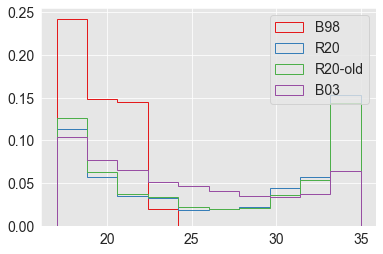

In [7]:
fig,ax=plt.subplots()
h=plt.hist(subdrfs['system_spts'], density=True, range=[17, 35],
           log=False, histtype='step',  label='B98')
h=plt.hist(romandall['system_spts'], log=False, histtype='step',  range=[17, 35],
           label='R20',  density=True)
h=plt.hist(romandrfs['system_spts'], log=False, histtype='step',  range=[17, 35],
           label='R20-old',  density=True)
h=plt.hist(baraffe['system_spts'], log=False, range=[17, 35],
           histtype='step',  label='B03', 
           density=True)

plt.legend()

In [8]:
#plt.hist?

In [9]:
dff= popsims.create_population(baraffe,s, kind='disk')
sd_dff= popsims.create_population(romandrfs, s, kind='halo')
#gh
#before I start making plots
dff=dff[dff.spt>=15.].reset_index(drop=True)
sd_dff=sd_dff[sd_dff.spt>=15.].reset_index(drop=True)

In [10]:
dff['mu']= (dff.mu_alpha**2+dff.mu_delta**2)**0.5
sd_dff['mu']=(sd_dff.mu_alpha**2+sd_dff.mu_delta**2)**0.5

In [11]:
#sd_dff.mu.min(), dff.mu.min()

In [12]:
cmap = plt.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=17, vmax=42)

In [13]:
#make cuts 
cuts={#'WFIRST_WFIZ':[1, 28.2],\
      'WFIRST_WFIY':[1, 26.7],\
      'WFIRST_WFIJ':[1, 26.9],\
      'WFIRST_WFIH':[1, 26.7],\
      'WFIRST_WFIF':[1,26.2]}


def number_counts_cut(key, ax, cut_dict):
    p= popsims.Pointing(coord=s, name='wfirst0')
    p.mag_limits=cut_dict
    df_cut= dff[dff[key] < cut_dict[key][1]]
    #print('before cut {}'.format(dff.d.max()))
    #print('After cut {}'.format(df_cut.d.max()))
    sd_cut=sd_dff[sd_dff[key] <cut_dict[key][1]]
    #luminosity function
    model_name='baraffe2003'
    lf=pd.read_pickle('/Users/caganze/research/wisps/db/lf_scales.pkl')
    #scale lf
    scale=lf[model_name]
    sn=len(df_cut[np.logical_and(df_cut.teff>=450, df_cut.teff<=1950)])
    #number counts
    ncounts={}
    dct= p.distance_limits[key]
    
    for spt in np.arange(17, 40):
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.9)]
        sdf_select= sd_cut[np.logical_and(sd_cut.spt>=spt, sd_cut.spt<spt+0.9)]
        
        vol=popsims.volume_calc(p.coord.l.radian, p.coord.b.radian,
                                   dct[spt][0], dct[spt][1], H)*(FOV.to(u.radian**2))
        #ncounts.update({spt:vol*(scale[-1]/sn)*len(df_select)})
        #print (spt, np.round(dct[spt][1]), vol, df_select.d.max())
        #nbrs, _=np.histogram(df_select.d.values, bins=bins, 
        #                  density=False, cumulative=True)
        #nbrs_sd, _=np.histogram(sdf_select.d.values, bins=bins, 
        #                  density=False, cumulative=True)
        res0 = scipy.stats.cumfreq(np.log10(df_select.d.values), numbins=32)
        bins0 = res0.lowerlimit + np.linspace(0, res0.binsize*res0.cumcount.size,
                                 res0.cumcount.size)
        nbrs=res0.cumcount
        
        res1 = scipy.stats.cumfreq(np.log10(sdf_select.d.values), numbins=32)
        bins1 = res1.lowerlimit + np.linspace(0, res1.binsize*res1.cumcount.size,
                                 res1.cumcount.size)
        nbrs_sd=res1.cumcount
        
        cnbrs=nbrs*vol*(scale[-1]/sn)/(FOV.to(u.deg**2))
        #sd_cnbrs=np.append(0, nbrs_sd)
        sd_cnbrs=nbrs_sd
        
        #print(np.nanmax(0.0051*(sd_cnbrs/np.nanmax(sd_cnbrs))))
        ax.plot(bins0, cnbrs, label=splat.typeToNum(spt),  color=cmap(norm(spt)))
        
        if spt in [17, 25, 37]:
            ax.plot(bins1, 0.0051*(sd_cnbrs/np.nanmax(sd_cnbrs))*np.nanmax(cnbrs), 
                linestyle='--', label='Halo {}'.format(splat.typeToNum(spt)), 
                color=cmap(norm(spt)))
                
        ncounts.update({s: np.nansum( cnbrs)})
    #print ('counts {}'.format( ncounts))
    return df_cut,  sd_cut

def get_numbers(fov0, points, cuts):
    NCOUNTS={}
    for k in cuts.keys():
        s=points[k]
        fov=fov0[k]
        dff= popsims.create_population(baraffe,s, kind='disk')
        sd_dff= popsims.create_population(romandrfs, s, kind='halo')
        
        dff=dff[dff.spt>=15.].reset_index(drop=True)
        sd_dff=sd_dff[sd_dff.spt>=15.].reset_index(drop=True)

        df_cut= make_cuts(dff, k, cuts)
        sd_cut=make_cuts(sd_dff, k, cuts)

        nxbr_counts=[]
        p=popsims.Pointing(coord=s)
        dct= get_average_distance_limits(p, k, cuts)

        model_name='baraffe2003'
        lf=pd.read_pickle('/Users/caganze/research/wisps/db/lf_scales.pkl')
        #scale lf
        scale=lf[model_name]
        sn=len(df_cut[np.logical_and(df_cut.teff>=450, df_cut.teff<=1950)])
        sca_sdf=len(df_cut)/len(sd_cut)

        for spt in [17, 25, 35, 40]:

            df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]
            sdf_select= sd_cut[np.logical_and(sd_cut.spt>=spt, sd_cut.spt<spt+0.99)]

            vol=popsims.volume_calc(s.l.radian, s.b.radian,
                                       1., dct[spt], H)*(fov.to(u.radian**2))
            nbrs=len(df_select)
            sd_nbrs= len(sdf_select)

            cnbrs=nbrs*vol*(scale[-1]/sn)/(fov.to(u.deg**2))
            sd_cnbrs=sd_nbrs*vol*(scale[-1]/sn)*sca_sdf/(fov.to(u.deg**2))


            nxbr_counts.append([cnbrs, 0.0051*sd_cnbrs])
            #print (sd_cnbrs/cnbrs)

        NCOUNTS[k]=nxbr_counts#, df]
    return NCOUNTS
        



In [14]:
cuts.keys()
CUTS=dict(zip(['wfirst{}'.format(x) for x in np.arange(len(cuts))],\
              [{x: cuts[x]} for x in cuts.keys()]))
FOVS=dict(zip(['wfirst{}'.format(x) for x in np.arange(len(cuts))],\
              [2000*(u.degree**2) for x in cuts]))
PNTS=dict(zip(['wfirst{}'.format(x) for x in np.arange(len(cuts))],\
              [s for x in cuts]))

In [15]:
 lf=pd.read_pickle('/Users/caganze/research/wisps/db/lf_scales.pkl')['baraffe2003']

In [16]:
lf[1]/lf[0]

0.060924859285332617

In [114]:
#get_numbers?
def make_cuts(df, survey, cut_dict):
    dcts=cut_dict[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, survey, cut_dict):
    p.mag_limits=cut_dict[survey]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

def tick_function(locs, distlimits):
   
    return ["{:.1f} kpc".format(distlimits[x][-1]/1000) for x in locs]

In [18]:
NDEEP=get_numbers(FOVS, PNTS, CUTS)

{'wfirst0': {'WFIRST_WFIY': [1, 26.7]},
 'wfirst1': {'WFIRST_WFIJ': [1, 26.9]},
 'wfirst2': {'WFIRST_WFIH': [1, 26.7]},
 'wfirst3': {'WFIRST_WFIF': [1, 26.2]}}

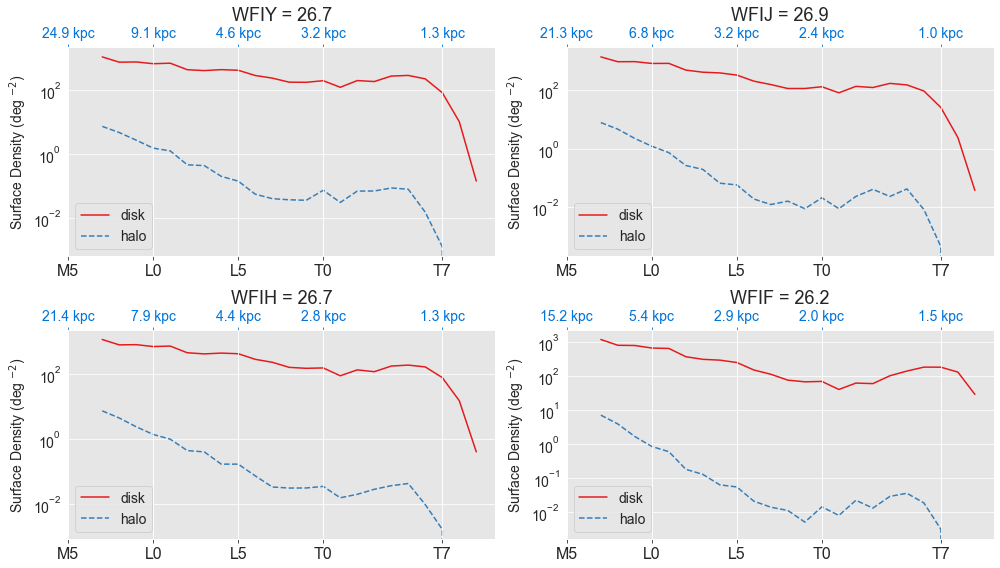

In [118]:
fig, ax=plt.subplots(2, 2, figsize=(14, 8))
df_cuts=[]
for k, a in zip(CUTS.keys(), np.concatenate(ax)):
    arr=np.vstack(np.array([[x.value for x in y] for y in NDEEP[k]]))
    #a.set_xscale('log')
    a.semilogy( np.arange(17,40), arr[:,0], label='disk')
    a.semilogy( np.arange(17,40), arr[:,1], label='halo', linestyle='--')
    a.set_ylabel(r'Surface Density (deg $^{-2}$)')
    a.set_xticks([15, 20, 25, 30, 37])
    a.legend()
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T7'], fontsize=16)
    
    p= popsims.Pointing(coord=s, name='wfirst0')
    p.mag_limits=CUTS[k]
    ax2 = a.twiny()
    ax2.set_xlim(a.get_xlim())
    k0=[x for x in CUTS[k].keys()][0]
    new_tick_locations = np.array([15, 20, 25, 30, 37])
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations, p.distance_limits[k0]))
    
    k0=[i for i in CUTS[k].keys()][0]
    
    ttl=a.set_title('{} = {}'.format(k0.replace('WFIRST_', ''), CUTS[k][k0][-1]), fontsize=18)
    ttl.set_position([.5, -1.05])
    ax2.tick_params(colors='#0074D9', which='both') 
    #a.set_xlim(0, 10000)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/wfirst_deep_numbers.pdf', dpi=600)

In [71]:
NGRISM=get_numbers(GFOVS, GPNTS, grism_cuts)

In [94]:
#

In [99]:
#

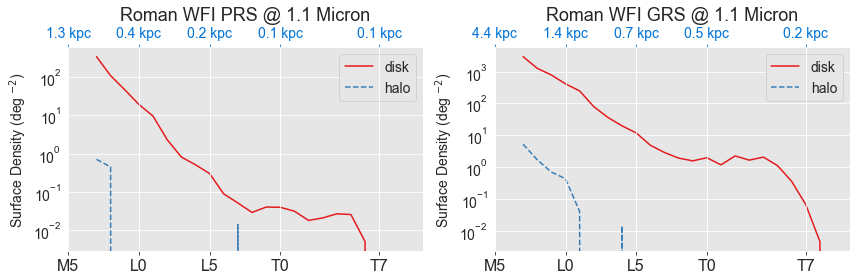

In [119]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
for k, a in zip(grism_cuts.keys(),ax):
    arr=np.vstack(np.array([[x.value for x in y] for y in NGRISM[k]]))
    #a.set_xscale('log')
    a.semilogy( np.arange(17,40), arr[:,0], label='disk')
    a.semilogy( np.arange(17,40), arr[:,1], label='halo', linestyle='--')
    a.set_ylabel(r'Surface Density (deg $^{-2}$)')
    a.set_xticks([15, 20, 25, 30, 37])
    a.legend()
    a.set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T7'], fontsize=16)
    
    p= popsims.Pointing(coord=s, name='wfirst0')
    p.mag_limits=grism_cuts[k]
    ax2 = a.twiny()
    ax2.set_xlim(a.get_xlim())
    k0=[x for x in grism_cuts[k].keys()][0]
    new_tick_locations = np.array([15, 20, 25, 30, 37])
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations, p.distance_limits[k0]))
    ax2.tick_params(colors='#0074D9', which='both') 
    
ttl=ax[0].set_title('Roman WFI PRS @ 1.1 Micron', fontsize=18)
ttl.set_position([.5, -1.05])

ttl1=ax[1].set_title('Roman WFI GRS @ 1.1 Micron', fontsize=18)
ttl1.set_position([.5, -1.05])


plt.tight_layout()
plt.savefig(popsims.FIGURES+'/wfirst_grism_numbers.pdf', dpi=600)

In [115]:
ttl.set_position?

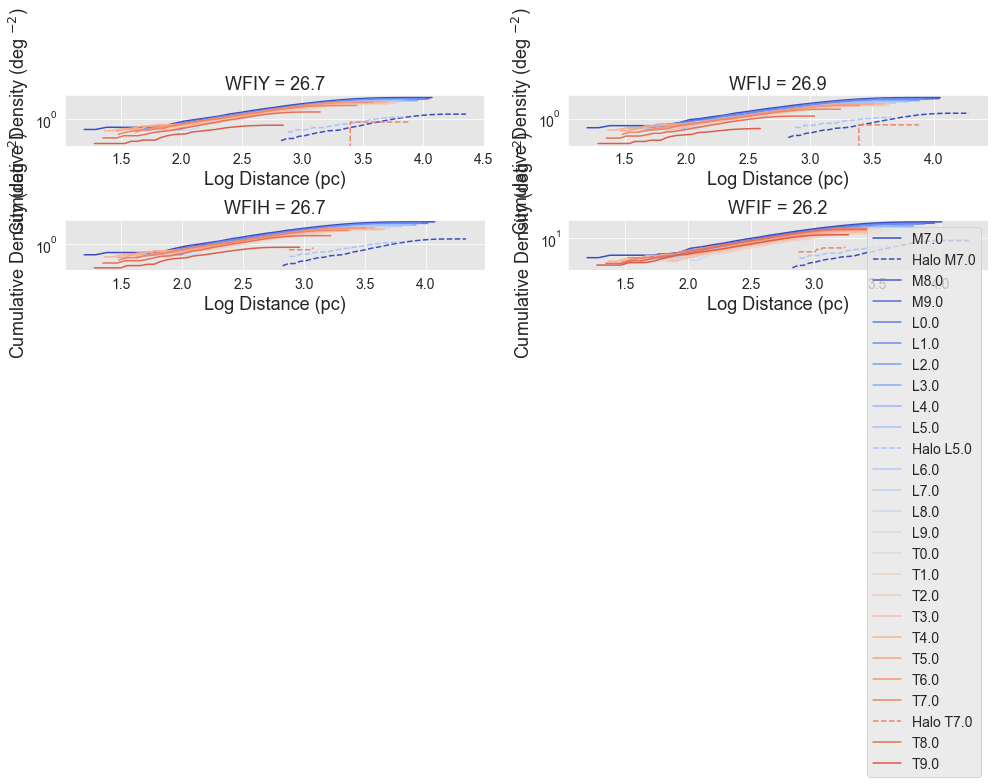

In [22]:
fig, ax=plt.subplots(2, 2, figsize=(14, 8))
df_cuts=[]
for k, a in zip(cuts.keys(), np.concatenate(ax)):
    df_cuts.append(number_counts_cut(k, a, cuts))
    #a.set_xscale('log')
    a.set_yscale('log')
    a.set_title(k)
    a.set_ylabel(r'Cumulative Density (deg $^{-2}$)', fontsize=18)
    a.set_xlabel(r'Log Distance (pc)', fontsize=18)
    a.set_title('{} = {}'.format(k.replace('WFIRST_', ''), cuts[k][-1]), fontsize=18)

#a.legend()
    #a.set_xlim(0, 10000)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/wfirst_distances.pdf', dpi=600)

In [23]:
grism_cuts={
      'GRS':{'WFIRST_WFIJ':[1, 20.8]},
    'PRS':{'WFIRST_WFIJ':[1, 23.5]}}

In [67]:
#cuts.keys()
GCUTS=dict(zip(['wfirst{}'.format(x) for x in np.arange(len(grism_cuts))],\
              [{x: grism_cuts[x]} for x in grism_cuts.keys()]))
GFOVS=dict(zip([x for x in grism_cuts.keys()],\
              [2000*(u.degree**2) for x in grism_cuts]))
GPNTS=dict(zip([ x for x in grism_cuts.keys()],\
              [s for x in grism_cuts]))

{'wfirst0': <Quantity 2000. deg2>,
 'wfirst1': <Quantity 2000. deg2>,
 'wfirst2': <Quantity 2000. deg2>,
 'wfirst3': <Quantity 2000. deg2>,
 'wfirst4': <Quantity 2000. deg2>,
 'wfirst5': <Quantity 2000. deg2>}

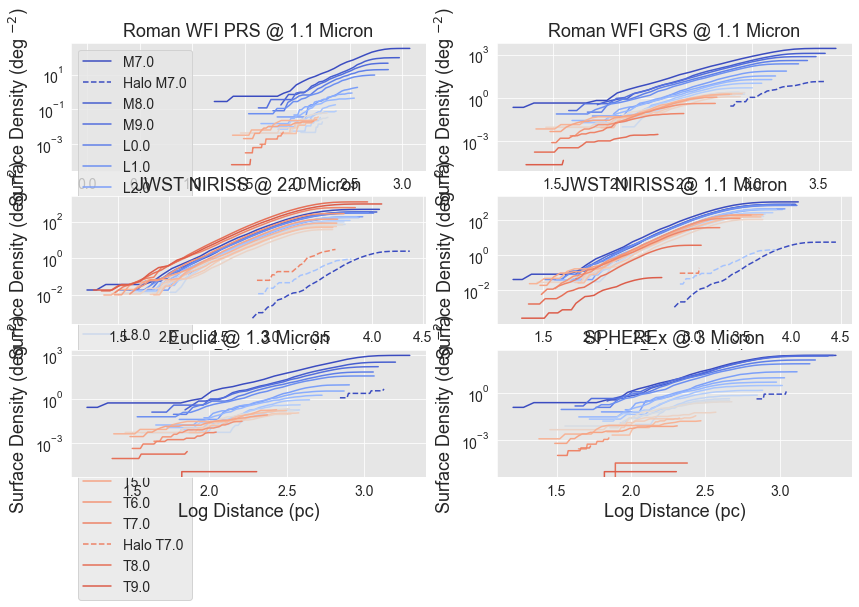

In [25]:
fig, ax=plt.subplots(ncols=2, nrows=3, figsize=(14, 8))
#df_cuts=[]
for k, a in zip(grism_cuts.keys(),np.concatenate(ax)):
    #print (grism_cuts[k])
    number_counts_cut(list(grism_cuts[k].keys())[0], a, grism_cuts[k])
    #a.set_xscale('log')
    a.set_yscale('log')
    #a.set_title(k)
    a.set_ylabel(r'Surface Density (deg $^{-2}$)', fontsize=18)
    a.set_xlabel(r'Log Distance (pc)', fontsize=18)
    #a.set_title('{} = {}'.format(k.replace('WFIRST_', ''), cuts[k][-1]))

ax[0][0].set_title('Roman WFI PRS @ 1.1 Micron', fontsize=18)
ax[0][1].set_title('Roman WFI GRS @ 1.1 Micron', fontsize=18)

ax[1][0].set_title('JWST NIRISS @ 2.0 Micron', fontsize=18)
ax[1][1].set_title('JWST NIRISS @ 1.1 Micron', fontsize=18)

ax[2][0].set_title('Euclid @ 1.3 Micron', fontsize=18)
ax[2][1].set_title('SPHEREx @ 3 Micron', fontsize=18)

#ax[0][0].legend()
#ax[0].set_xlim(1.5, 3.2 )
#ax[1].set_xlim(1.5, 4.)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/all_spectroscopic.jpeg', dpi=600)

In [26]:
#df_cuts

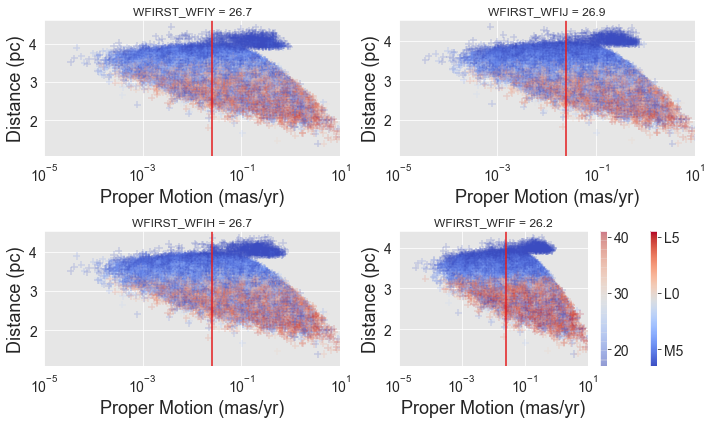

In [27]:
fig, ax=plt.subplots(2, 2, figsize=(10, 6))
for idx in np.arange(len(cuts.keys())):
    k=[x for x in cuts.keys()][idx]
    dffnn=df_cuts[idx][0]
    sd_dffnn=df_cuts[idx][1].sample(n=int(len(dffnn)*0.0051))
    comb= pd.concat([dffnn, sd_dffnn])
    a=np.concatenate(ax)[idx]
    #comb['mu']=
    
    c=a.scatter(comb.mu,
              np.log10(comb.d), c=comb.spt, marker='+',
              cmap='coolwarm', s=50, alpha=0.2,  vmin=17, vmax=41)
    
    #sns.kdeplot((comb.mu_alpha**2+comb.mu_delta**2)**0.5,
    #          np.log10(comb.d), levels=np.flip(1-np.array([ 0.5, 0.75, 0.89, 0.94, 0.96])), 
    #        color="#001f3f", linewidths=1, ax=a)
    
    #c=a.scatter(np.log10((comb.mu_alpha**2+comb.mu_delta**2)**0.5),
    #          np.log10(comb.d), c=comb.spt, 
    #          cmap='coolwarm', s=1, alpha=0.2, vmin=17, vmax=41)
    
    a.axvline(25*(10**-3))
    a.set_title('{} = {}'.format(k, cuts[k][-1]))
    #a.set_yscale('log')
    a.set_xlabel(r'Proper Motion (mas/yr)', fontsize=18)
    a.set_ylabel(r'Distance (pc)',  fontsize=18)
    a.set_xscale('log')
    a.set_xlim([1e-5, 1e1])

#df
#cax2 = fig.add_axes([0.07, 1.0, 1.0, 0.2])
norm= matplotlib.colors.Normalize(vmin=17,vmax=41)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar=plt.colorbar(mp, orientation='vertical')
cbar.ax.set_yticks([15, 20, 25, 30, 35])
cbar.ax.set_yticklabels(['M5', 'L0', 'L5', 'T0', 'T5'])
plt.colorbar(c)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/wfirst_proper_motion.jpeg', dpi=600)

In [28]:
dffnn=dffnn[dffnn['WFIRST_WFIF'] <26.2]
sd_dffnn=sd_dffnn[sd_dffnn['WFIRST_WFIF'] <26.2]

In [29]:
color_keys=[['R-J', 'J-H'],
            ['J-H', 'H-F']]
            #['R-K', 'J-K']]

In [30]:
dffnn['WFIRST_WFIK']=dffnn['2MASS_K']
sd_dffnn['WFIRST_WFIK']=sd_dffnn['2MASS_K']

In [31]:
#3dhst data 
from astropy.io import ascii
hst3d= ascii.read('/users/caganze/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat').to_pandas()

In [32]:
#hst3d
def magnitude(flux):
        return 25.0-2.5*np.log10(flux)
    
def mag_err(combined):
        #combined is a pandas table with flux and flux_error
    		if  np.isnan(combined['flux']):
    			return np.nan
    		else: return abs(0.434*2.5*combined['flux_error']/combined['flux'])

In [33]:
for k in ['F125', 'F606', 'F140', 'F160', 'F814']:
    hst3d[k]=magnitude(hst3d['f_{}W'.format(k)])
    #hst3d[k+'er']=

In [34]:
#hst3d=hst3d[hst3d.star_flag !=1]

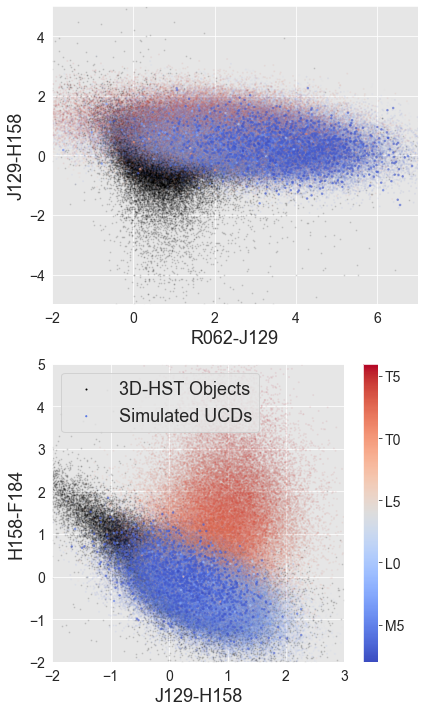

In [35]:
#color-color plots
fig, ax=plt.subplots(nrows=2, figsize=(6, 10))
ax[0].scatter(hst3d['F606']-hst3d['F125'], 
              hst3d['F125']-hst3d['F140'], 
              s=1, alpha=0.1, color='k', label='3D-HST Objects')

ax[1].scatter(hst3d['F125']-hst3d['F140'], 
              hst3d['F140']-hst3d['F160'], 
              s=1, alpha=0.1, color='k', label='3D-HST Objects')

for pair, a in zip(color_keys, ax):
    xkeys= ['WFIRST_WFI'+pair[0].split('-')[0], 'WFIRST_WFI'+pair[0].split('-')[1]]
    ykeys= ['WFIRST_WFI'+pair[1].split('-')[0], 'WFIRST_WFI'+pair[1].split('-')[1]]
    c=a.scatter(dffnn[xkeys[0]]-dffnn[xkeys[1]], 
               dffnn[ykeys[0]]-dffnn[ykeys[1]],
                s=5, marker='.', alpha=0.05, c=dffnn.spt, 
              cmap='coolwarm', label='Simulated UCDs', vmin=15, vmax=41)
    a.scatter(sd_dffnn[xkeys[0]]-sd_dffnn[xkeys[1]], 
               sd_dffnn[ykeys[0]]-sd_dffnn[ykeys[1]],
                s=10, marker='.', alpha=0.5, c=sd_dffnn.spt, cmap='coolwarm',
              vmin=15, vmax=41)

ax[0].set_xlabel('R062-J129', fontsize=18)
ax[0].set_ylabel('J129-H158', fontsize=18)

ax[1].set_ylabel('H158-F184', fontsize=18)
ax[1].set_xlabel('J129-H158', fontsize=18)

ax[0].set_xlim([-2, 7])
ax[0].set_ylim([-5, 5])

ax[1].set_xlim([-2, 3])
ax[1].set_ylim([-2, 5])


norm= matplotlib.colors.Normalize(vmin=17,vmax=41)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar=plt.colorbar(mp, orientation='vertical')
cbar.ax.set_yticks([15, 20, 25, 30, 35])
cbar.ax.set_yticklabels(['M5', 'L0', 'L5', 'T0', 'T5'])
leg=ax[1].legend(fontsize=18)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig(popsims.FIGURES+'/wfirst_colors.jpeg', rasterized=True)


In [36]:
int((len(dffnn)+len(sd_dffnn))*0.0051), len(sd_dffnn)

(1411, 1404)

In [37]:
dff.keys()

Index(['WFIRST_WFIJ', 'WFIRST_WFIY', 'WFIRST_WFIZ', 'WFIRST_WFIH',
       'WFIRST_WFIF', 'WFIRST_WFIR', 'EUCLID_J', 'EUCLID_H', 'EUCLID_Y',
       'LSST_Y', 'LSST_Z', 'LSST_R', 'NIRCAM_F115W', 'NIRCAM_F140M',
       'NIRCAM_F150W', 'NIRCAM_F200W', '2MASS_K', 'WISE_W1', 'spt', 'teff',
       'age', 'd', 'u', 'v', 'w', 'rv', 'mu_alpha', 'mu_delta', 'vtan', 'mu'],
      dtype='object')

In [38]:
comb0= pd.concat([dff, sd_dff])

comb0['H_WFIRST_WFIH']= comb0['WFIRST_WFIH']+ 5*np.log10(comb0.mu)-10

comb0['H_WFIRST_WFIF']= comb0['WFIRST_WFIF']+ 5*np.log10(comb0.mu)-10

comb0['H_EUCLID_H']= comb0['EUCLID_H']+ 5*np.log10(comb0.mu)-10

comb= comb0[comb0['WFIRST_WFIF'] <26.2]
comb_euclid=comb0[comb0['EUCLID_H'] <27.0]

mask=np.logical_and(comb.mu >1e-6, comb.d<1e5)
mask_euclid=np.logical_and(comb_euclid.mu >1e-6, comb_euclid.d<1e5)

In [39]:
#p

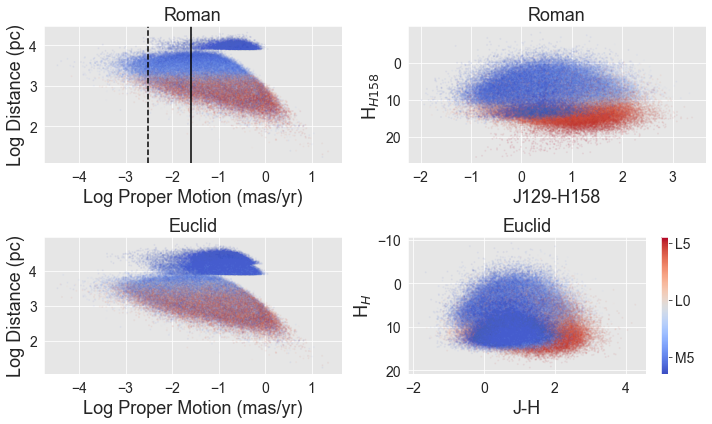

In [40]:
fig, (ax, ax1)=plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
ax[0].scatter(np.log10(comb.mu), np.log10(comb.d), s=5, marker='.', alpha=0.05, c=comb.spt, 
              cmap='coolwarm', label='Simulated UCDs', vmin=15, vmax=41)

#sns.kdeplot(np.log10(comb.mu)[mask],
#              np.log10(comb.d)[mask], levels=np.flip(1-np.array([ 0.5, 0.75, 0.89, 0.94, 0.96])), 
#            color="#001f3f", linewidths=1, ax=ax[0])

ax[1].scatter(comb.WFIRST_WFIJ-comb.WFIRST_WFIH, comb['H_WFIRST_WFIH'], 
              s=5, marker='.', alpha=0.05, c=comb.spt, 
              cmap='coolwarm', label='Simulated UCDs', vmin=15, vmax=41)

ax1[0].scatter(np.log10(comb_euclid.mu), np.log10(comb_euclid.d),
               s=5, marker='.', alpha=0.05, c=comb_euclid.spt, 
              cmap='coolwarm', label='Simulated UCDs', vmin=15, vmax=41)

#sns.kdeplot(np.log10(comb_euclid.mu)[mask_euclid],
#              np.log10(comb_euclid.d)[mask_euclid], levels=np.flip(1-np.array([ 0.5, 0.75, 0.89, 0.94, 0.96])), 
#            color="#001f3f", linewidths=1, ax=ax1[0])

ax1[1].scatter(comb_euclid.EUCLID_J-comb_euclid.EUCLID_H, comb_euclid['H_EUCLID_H'], 
              s=5, marker='.', alpha=0.05, c=comb_euclid.spt, 
              cmap='coolwarm', label='Simulated UCDs', vmin=15, vmax=41)
#ax[1].scatter(sd_dffnn.WFIRST_WFIR-sd_dffnn.WFIRST_WFIJ, sd_dffnn['H_WFIRST_WFIH'], 
#              s=5, marker='.', alpha=0.05, c=dffnn.spt, 
#              cmap='coolwarm', label='Simulated UCDs', vmin=15, vmax=41)
#ax1[0].axvline(np.log10(10*(10**-3)), c='k', label=r'HLS')

ax[0].axvline(np.log10(25*(10**-3)), c='k', linestyle='-')
ax[0].axvline(np.log10(3*(10**-3)), c='k', linestyle='--')

#ax1[0].axvline(np.log10(10/10), c='k', linestyle='--')
ax1[0].set_xlabel(r'Log Proper Motion (mas/yr)', fontsize=18)
ax1[0].set_ylabel(r'Log Distance (pc)',  fontsize=18)
#ax1[0].legend()
for a in ax:
    a.set_title('Roman', fontsize=18)
for a in ax1:
    a.set_title('Euclid', fontsize=18)

ax[1].invert_yaxis()
ax[0].set_xlabel(r'Log Proper Motion (mas/yr)', fontsize=18)
ax[0].set_ylabel(r'Log Distance (pc)',  fontsize=18)

ax[1].set_ylabel(r'H$_{H158}$', fontsize=18)
ax[1].set_xlabel('J129-H158', fontsize=18)

ax1[1].invert_yaxis()
ax1[1].set_ylabel(r'H$_{H}$', fontsize=18)
ax1[1].set_xlabel('J-H', fontsize=18)


norm= matplotlib.colors.Normalize(vmin=17,vmax=41)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar=plt.colorbar(mp, orientation='vertical')
cbar.ax.set_yticks([15, 20, 25, 30, 35])
cbar.ax.set_yticklabels(['M5', 'L0', 'L5', 'T0', 'T5'])

plt.tight_layout()
plt.savefig(popsims.FIGURES+'/wfirst_recuded_motion.jpeg', rasterized=True)

In [41]:
p= popsims.Pointing(coord=s, name='wfirst0')
p.mag_limits=cuts

In [42]:
p.mag_limits

{'WFIRST_WFIY': [1, 26.7],
 'WFIRST_WFIJ': [1, 26.9],
 'WFIRST_WFIH': [1, 26.7],
 'WFIRST_WFIF': [1, 26.2]}

In [43]:
dffnn['H_WFIRST_WFIH']= dffnn['WFIRST_WFIH']+ 5*np.log10(dffnn.mu)-10
dffnn['H_WFIRST_WFIF']= dffnn['WFIRST_WFIF']+ 5*np.log10(dffnn.mu)-10

sd_dffnn['H_WFIRST_WFIH']= sd_dffnn['WFIRST_WFIH']+ 5*np.log10(sd_dffnn.mu)-10
sd_dffnn['H_WFIRST_WFIF']= sd_dffnn['WFIRST_WFIF']+ 5*np.log10(sd_dffnn.mu)-10


In [44]:
len(sd_dffnn['H_WFIRST_WFIH']), len(sd_dffnn.WFIRST_WFIJ)

(1404, 1404)

In [45]:
comb['j-h']=dffnn.WFIRST_WFIJ-dffnn.WFIRST_WFIH

In [46]:
comb=comb.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

NameError: name 'wisps' is not defined

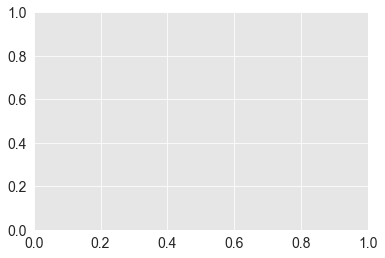

In [47]:
fig, ax=plt.subplots()
#dffnn, sd_dffnn
wisps.tools.plot_annotated_heatmap(ax,
    comb,
    20,
    ['j-h', 'H_WFIRST_WFIH', 'age'],
    cmap='cubehelix',
    vmin=0.0,
    vmax=13.5,
    textsize=14,
    annotate='third_value')

ax.set_ylabel(r'H$_{H158}$', fontsize=18)
ax.set_xlabel('J129-H158', fontsize=18)


In [ ]:
#p.distance_limits['WFIRST_WFIJ']

In [ ]:
BHJ

In [ ]:
fig, ax=plt.subplots()

ax.scatter( dffnn.v, ( dffnn.w**2+dffnn.u**2)**0.5, c=np.log10(dffnn.age), marker=',',
              cmap='viridis', s=5,alpha=0.01,vmin=np.log10(0.01), vmax=np.log10(13.5))

ax.scatter( sd_dffnn.v, ( sd_dffnn.w**2+sd_dffnn.u**2)**0.5, 
           c=np.log10(sd_dffnn.age), marker='*',
              cmap='viridis', s=sd_dffnn.age,vmin=np.log10(0.01), vmax=np.log10(13.5))
plt.ylabel(r'$(U^2+W^2)^{0.5}$')
plt.xlabel(r'$V$')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
plt.xticks?

In [ ]:
for k in [17, 25, 35, 40]:
    print ('{} {:.0f} pc in {}'.format(splat.typeToNum(k), p.distance_limits['2MASS_K'][k][1], 'K'))
    print ('{} {:.0f} pc in {}'.format(splat.typeToNum(k), \
                                   p.distance_limits['WFIRST_WFIH'][k][1], 'H'))
    print ('{} {:.0f} pc in {}'.format(splat.typeToNum(k), \
                                   p.distance_limits['WFIRST_WFIJ'][k][1], 'J'))
    print ('---------------------------------------')

In [ ]:
hj

In [ ]:
p= popsims.Pointing(coord=s, name='wfirst0')
p2= popsims.Pointing(coord=s, density='spheroid')

In [ ]:
h=plt.hist(p.draw_distances(10, 7e4, 350, nsample=1e6), 
           density=True, cumulative=True, bins='auto', histtype='step',
           label='disk')
h=plt.hist(p2.draw_distances(10, 7e4, 350, nsample=1e6),
           density=True,  cumulative=True,bins='auto', histtype='step',
           label='halo')
plt.xscale('log')
plt.legend()
#plt.yscale('log')

In [ ]:
FOV.to(u.arcmin**2)*10**-2